<a href="https://colab.research.google.com/github/Zonner93/cnn-python-keras/blob/main/cnn_missile_vs_fighter_jet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Klasyfikator binarny - Pocisk czy Myśliwiec

### Czyszczenie katalogu roboczego

In [ ]:
!ls

sample_data


In [1]:
!rm -rf sample_data/

### Importowanie bibliotek

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

### Pobieranie danych

In [3]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
!unzip -q flying-vehicles.zip

--2022-01-26 18:59:07--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 142.250.152.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G   146MB/s    in 13s     

2022-01-26 18:59:21 (114 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



### Przygotowanie zbiorów: treningowego, walidacyjnego oraz testowego

In [9]:
# !rm -rf ./images

In [10]:
BASE_DIR = './data/planes'
raw_number_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for dir in classes:
    raw_number_of_files[dir] = len(os.listdir(os.path.join(BASE_DIR, dir)))

raw_number_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [11]:
DATA_DIR = './images'

if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)

train_dir = os.path.join(DATA_DIR, 'train')  # ścieżka do katalogu danych trenujących
valid_dir = os.path.join(DATA_DIR, 'valid')  # ścieżka do katalogu danych walidacyjnych
test_dir = os.path.join(DATA_DIR, 'test')  # ścieżka do katalogu danych testujących

train_fighter_dir = os.path.join(train_dir, 'fighter')
train_missile_dir = os.path.join(train_dir, 'missile')

valid_fighter_dir = os.path.join(valid_dir, 'fighter')
valid_missile_dir = os.path.join(valid_dir, 'missile')

test_fighter_dir = os.path.join(test_dir, 'fighter')
test_missile_dir = os.path.join(test_dir, 'missile')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_fighter_dir,
        train_missile_dir,
        valid_fighter_dir,
        valid_missile_dir,
        test_fighter_dir,
        test_missile_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [12]:
missile_file_names = os.listdir(os.path.join(BASE_DIR, 'missile'))
fighter_file_names = os.listdir(os.path.join(BASE_DIR, 'fighter-jet'))

missile_file_names = [fname for fname in missile_file_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
fighter_file_names = [fname for fname in fighter_file_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [13]:
size = min(len(missile_file_names), len(fighter_file_names))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [14]:
for i, file_name in enumerate(missile_file_names):
    if i <= train_idx:
        src = os.path.join(BASE_DIR, 'missile', file_name)
        dst = os.path.join(train_missile_dir, file_name)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(BASE_DIR, 'missile', file_name)
        dst = os.path.join(valid_missile_dir, file_name)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(BASE_DIR, 'missile', file_name)
        dst = os.path.join(test_missile_dir, file_name)
        shutil.copyfile(src, dst)

for i, file_name in enumerate(fighter_file_names):
    if i <= train_idx:
        src = os.path.join(BASE_DIR, 'fighter-jet', file_name)
        dst = os.path.join(train_fighter_dir, file_name)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(BASE_DIR, 'fighter-jet', file_name)
        dst = os.path.join(valid_fighter_dir, file_name)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(BASE_DIR, 'fighter-jet', file_name)
        dst = os.path.join(test_fighter_dir, file_name)
        shutil.copyfile(src, dst)

print('drone - zbiór treningowy', len(os.listdir(train_missile_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_missile_dir)))
print('drone - zbiór testowy', len(os.listdir(test_missile_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_fighter_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_fighter_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_fighter_dir)))

drone - zbiór treningowy 921
drone - zbiór walidacyjny 263
drone - zbiór testowy 131
passenger - zbiór treningowy 921
passenger - zbiór walidacyjny 263
passenger - zbiór testowy 131


### Eksploracja danych

(-0.5, 299.5, 196.5, -0.5)

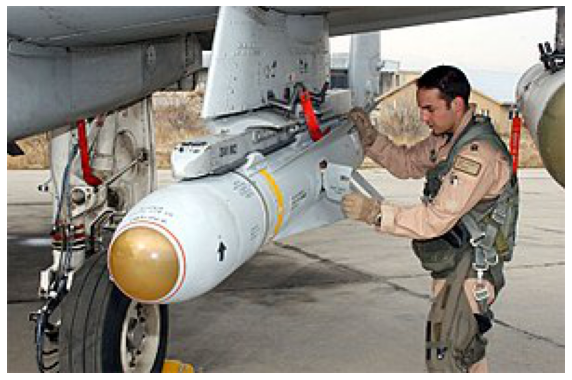

In [26]:
# @title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 691  # @param {type:'slider', min:0, max:920}
names_mapping = dict(enumerate(missile_file_names))
img_path = os.path.join(train_missile_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 799.5, 449.5, -0.5)

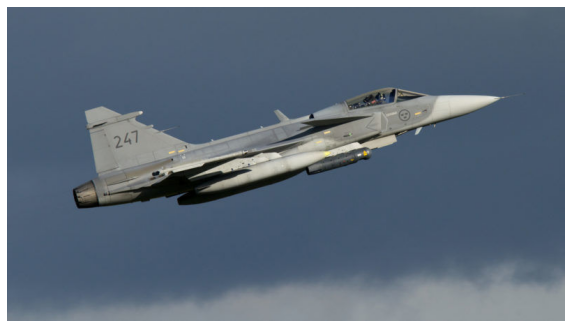

In [28]:
# @title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 83  # @param {type:'slider', min:0, max:920}
names_mapping = dict(enumerate(fighter_file_names))
img_path = os.path.join(train_fighter_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

### Augmentacja danych

In [29]:
train_data_generator = ImageDataGenerator(
    rotation_range=40,  # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1. / 255.,  # skalowanie
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2,  # poziome przekształcenia obrazu
    shear_range=0.2,  # zares losowego przycianania obrazu
    zoom_range=0.2,  # zakres losowego przybliżania obrazu
    horizontal_flip=True,  # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'  # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_data_generator = ImageDataGenerator(rescale=1. / 255.)

train_generator = train_data_generator.flow_from_directory(directory=train_dir,
                                                           target_size=(150, 150),
                                                           batch_size=32,
                                                           class_mode='binary')

valid_generator = valid_data_generator.flow_from_directory(directory=valid_dir,
                                                           target_size=(150, 150),
                                                           batch_size=32,
                                                           class_mode='binary')


Found 1842 images belonging to 2 classes.
Found 526 images belonging to 2 classes.


In [30]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    file_names = [os.path.join(directory, file_name) for file_name in os.listdir(directory)]
    img_path = file_names[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_data_generator.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

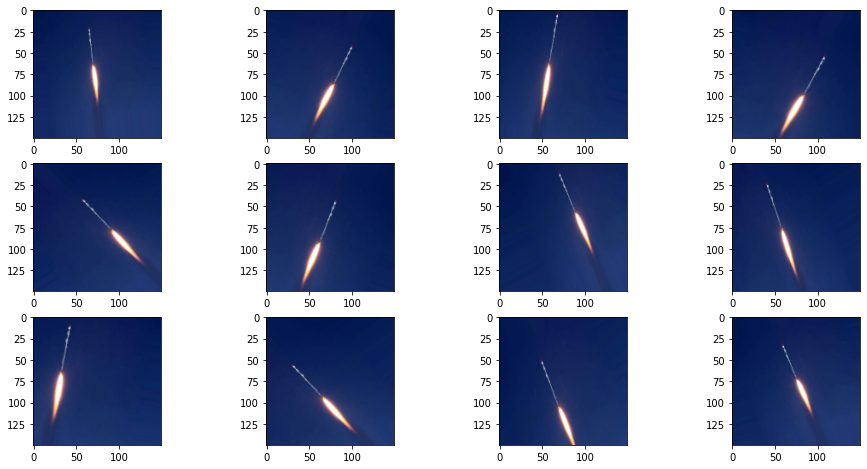

In [36]:
# @title Zbiór treningowy drone:
idx = 78  # @param {type:'slider', min:0, max:920}
display_augmented_images(train_missile_dir, idx)

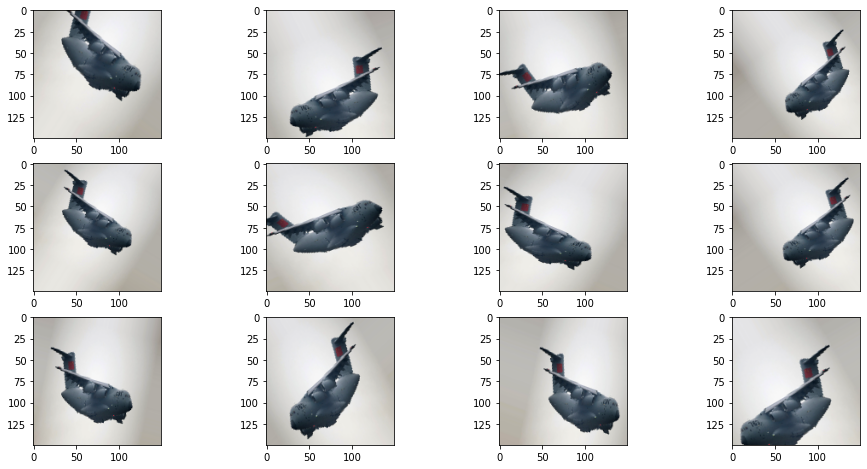

In [40]:
# @title Zbiór treningowy passenger:
idx = 796  # @param {type:'slider', min:0, max:920}
display_augmented_images(train_fighter_dir, idx)

### Budowa modelu

In [41]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [42]:
!rm -rf logs
!mkdir logs
tensorboard = TensorBoard(log_dir='logs')

In [61]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=100,
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/100
28/28 [==============================] - 28s 1s/step - loss: 0.6541 - accuracy: 0.6372 - val_loss: 0.6420 - val_accuracy: 0.5977
Epoch 2/100
28/28 [==============================] - 26s 943ms/step - loss: 0.6492 - accuracy: 0.6362 - val_loss: 0.5652 - val_accuracy: 0.7188
Epoch 3/100
28/28 [==============================] - 32s 1s/step - loss: 0.6214 - accuracy: 0.6667 - val_loss: 0.5935 - val_accuracy: 0.6875
Epoch 4/100
28/28 [==============================] - 27s 970ms/step - loss: 0.6276 - accuracy: 0.6730 - val_loss: 0.6304 - val_accuracy: 0.6602
Epoch 5/100
28/28 [==============================] - 27s 988ms/step - loss: 0.6245 - accuracy: 0.6531 - val_loss: 0.5316 - val_accuracy: 0.7656
Epoch 6/100
28/28 [==============================] - 28s 990ms/step - loss: 0.6381 - accuracy: 0.6373 - val_loss: 0.5324 - val_accuracy: 0.7734
Epoch 7/100
28/28 [==============================] - 28s 1s/step - loss: 0.6106 - accuracy: 0.6735 - val_loss: 0.6329 - val_accuracy: 0.6641
E

In [62]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki',
                      yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss',
                      yaxis_type='log')
    fig.show()


plot_hist(history)

### Ocena modelu na zbiorze testowym

In [63]:
test_data_generator = ImageDataGenerator(rescale=1. / 255.)
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob = y_prob.ravel()
y_prob

Found 262 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



array([0.11551 , 0.063286, 0.319343, 0.344518, 0.192852, 0.267268,
       0.467246, 0.793636, 0.568355, 0.392049, 0.234326, 0.279875,
       0.215232, 0.923638, 0.2106  , 0.648826, 0.616817, 0.951902,
       0.910484, 0.076331, 0.322118, 0.386649, 0.070198, 0.124791,
       0.308291, 0.032776, 0.35902 , 0.498457, 0.131776, 0.089547,
       0.193949, 0.13683 , 0.152028, 0.682012, 0.496585, 0.077415,
       0.471151, 0.477076, 0.0493  , 0.571527, 0.55435 , 0.558961,
       0.856672, 0.964566, 0.185557, 0.168479, 0.142796, 0.081741,
       0.135907, 0.29261 , 0.153387, 0.053434, 0.165481, 0.127935,
       0.339086, 0.148266, 0.425658, 0.33493 , 0.04446 , 0.149428,
       0.171732, 0.153896, 0.275198, 0.99293 , 0.153659, 0.128268,
       0.144271, 0.49715 , 0.079597, 0.775348, 0.549739, 0.369912,
       0.290117, 0.304068, 0.116027, 0.140649, 0.04922 , 0.338766,
       0.706057, 0.033783, 0.11976 , 0.261364, 0.925879, 0.175088,
       0.166084, 0.656373, 0.054244, 0.257884, 0.179335, 0.161

In [64]:
predictions  = pd.DataFrame({'y_prob': y_prob})
predictions['class'] = predictions['y_prob'].apply(lambda x: 1 if x > 0.5 else 0)
predictions

,y_prob,class
0,0.115510,0
1,0.063286,0
2,0.319343,0
3,0.344518,0
4,0.192852,0
...,...,...
257,0.246955,0
258,0.856007,1
259,0.978145,1
260,0.754387,1


In [65]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [66]:
y_pred = predictions['class'].values
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0])

In [67]:
test_generator.class_indices

{'fighter': 0, 'missile': 1}

In [68]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[107,  24],
       [ 35,  96]])

In [69]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       131
           1       0.80      0.73      0.76       131

    accuracy                           0.77       262
   macro avg       0.78      0.77      0.77       262
weighted avg       0.78      0.77      0.77       262



In [70]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors.head()

,y_true,y_pred
fighter/00000000.jpg,0,0
fighter/00000003.jpg,0,0
fighter/00000012.jpg,0,0
fighter/00000015.jpg,0,0
fighter/00000073.JPG,0,0


In [71]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_incorrect
fighter/00000000.jpg,0,0,0
fighter/00000003.jpg,0,0,0
fighter/00000012.jpg,0,0,0
fighter/00000015.jpg,0,0,0
fighter/00000073.JPG,0,0,0
...,...,...,...
missile/00001364.jpg,1,0,1
missile/00001392.png,1,1,0
missile/00001400.jpg,1,1,0
missile/00001415.png,1,1,0


In [72]:
errors[errors['is_incorrect'] == 1].index

Index(['fighter/00000104.jpg', 'fighter/00000110.jpg', 'fighter/00000193.jpg',
       'fighter/00000212.jpg', 'fighter/00000213.jpg', 'fighter/00000214.jpg',
       'fighter/00000216.jpg', 'fighter/00000495.jpg', 'fighter/00000568.jpg',
       'fighter/00000571.jpg', 'fighter/00000598.JPG', 'fighter/00000601.jpg',
       'fighter/00000616.jpg', 'fighter/00000942.jpg', 'fighter/00000997.jpg',
       'fighter/00001007.jpg', 'fighter/00001149.jpg', 'fighter/00001194.jpg',
       'fighter/00001254.jpg', 'fighter/00001652.jpeg', 'fighter/00001653.png',
       'fighter/00001809.jpg', 'fighter/00001819.jpg', 'fighter/00001821.jpg',
       'missile/00000033.jpg', 'missile/00000088.jpg', 'missile/00000097.jpeg',
       'missile/00000113.jpg', 'missile/00000161.JPG', 'missile/00000176.jpg',
       'missile/00000207.jpg', 'missile/00000254.jpg', 'missile/00000256.jpeg',
       'missile/00000277.jpg', 'missile/00000301.jpg', 'missile/00000349.JPG',
       'missile/00000385.jpg', 'missile/00000416.

(-0.5, 386.5, 252.5, -0.5)

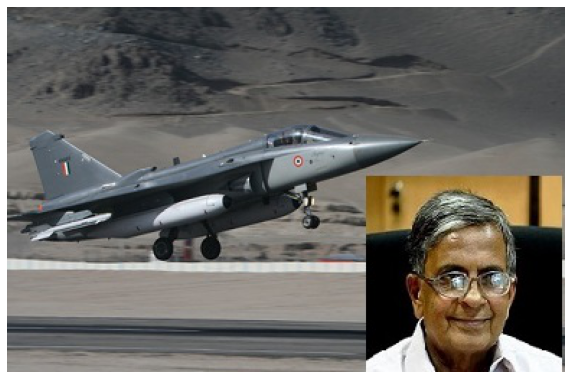

In [73]:
img_path = os.path.join(test_fighter_dir, '00001819.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 1199.5, 674.5, -0.5)

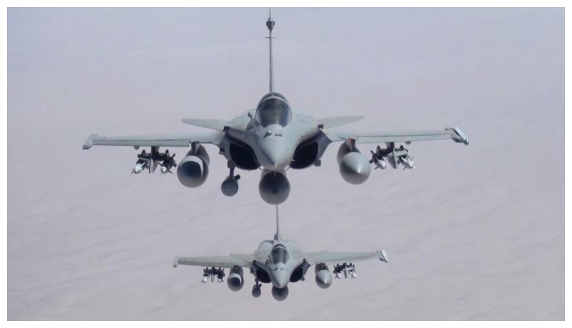

In [75]:
img_path = os.path.join(test_missile_dir, '00001421.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)